In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
from sklearn.metrics import auc
import os
import numpy as np
import pandas as pd 
import awkward as ak 
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
input_folder = "/eos/user/b/bmaier/ticl_ml_hackathon/samples/landingzone/single_electron/ntuples/"

In [ ]:
f = uproot.open(file)
t =  f["ticlNtuplizer/tracksters"]
calo = f["ticlNtuplizer/simtrackstersCP"]

In [7]:
calo.keys()

['stsCP_event',
 'stsCP_NClusters',
 'stsCP_NTracksters',
 'stsCP_time',
 'stsCP_timeError',
 'stsCP_regressed_energy',
 'stsCP_raw_energy',
 'stsCP_raw_em_energy',
 'stsCP_raw_pt',
 'stsCP_raw_em_pt',
 'stsCP_barycenter_x',
 'stsCP_barycenter_y',
 'stsCP_barycenter_z',
 'stsCP_trackster_barycenter_eta',
 'stsCP_trackster_barycenter_phi',
 'stsCP_EV1',
 'stsCP_EV2',
 'stsCP_EV3',
 'stsCP_eVector0_x',
 'stsCP_eVector0_y',
 'stsCP_eVector0_z',
 'stsCP_sigmaPCA1',
 'stsCP_sigmaPCA2',
 'stsCP_sigmaPCA3',
 'stsCP_id_probabilities',
 'stsCP_vertices_indexes',
 'stsCP_vertices_x',
 'stsCP_vertices_y',
 'stsCP_vertices_z',
 'stsCP_vertices_energy',
 'stsCP_vertices_correctedEnergy',
 'stsCP_vertices_correctedEnergyUncertainty',
 'stsCP_vertices_multiplicity']

In [4]:
import glob

files = glob.glob(f"{input_folder}/ntuples_13723002_*.root")

calos = [ ]
tracksters = [ ]

i = 0
N = 5
for file in files:
    if i >= N: break
    i+=1
    try:
        print('.', end="")
        f = uproot.open(file)
        t =  f["ticlNtuplizer/tracksters"]
        calo = f["ticlNtuplizer/simtrackstersCP"]
        calos.append(calo.arrays(["stsCP_trackster_barycenter_eta","stsCP_trackster_barycenter_phi","stsCP_barycenter_z"]))
        tracksters.append(t.arrays(["raw_energy","trackster_barycenter_eta","trackster_barycenter_phi","barycenter_z"]))
    except:
        print("error ", file)
        
df_calo = ak.concatenate(calos)
df_track = ak.concatenate(tracksters)

.....

In [33]:
t.keys()

['event',
 'NClusters',
 'NTracksters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'trackster_barycenter_eta',
 'trackster_barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity',
 'layer_cluster_seed']

In [25]:
df_calo.stsCP_trackster_barycenter_eta

<Array [[-2.58, -2.58, -2.94, ... 2.5, 2.5]] type='49449 * var * float32'>

Text(0, 1, 'phi')

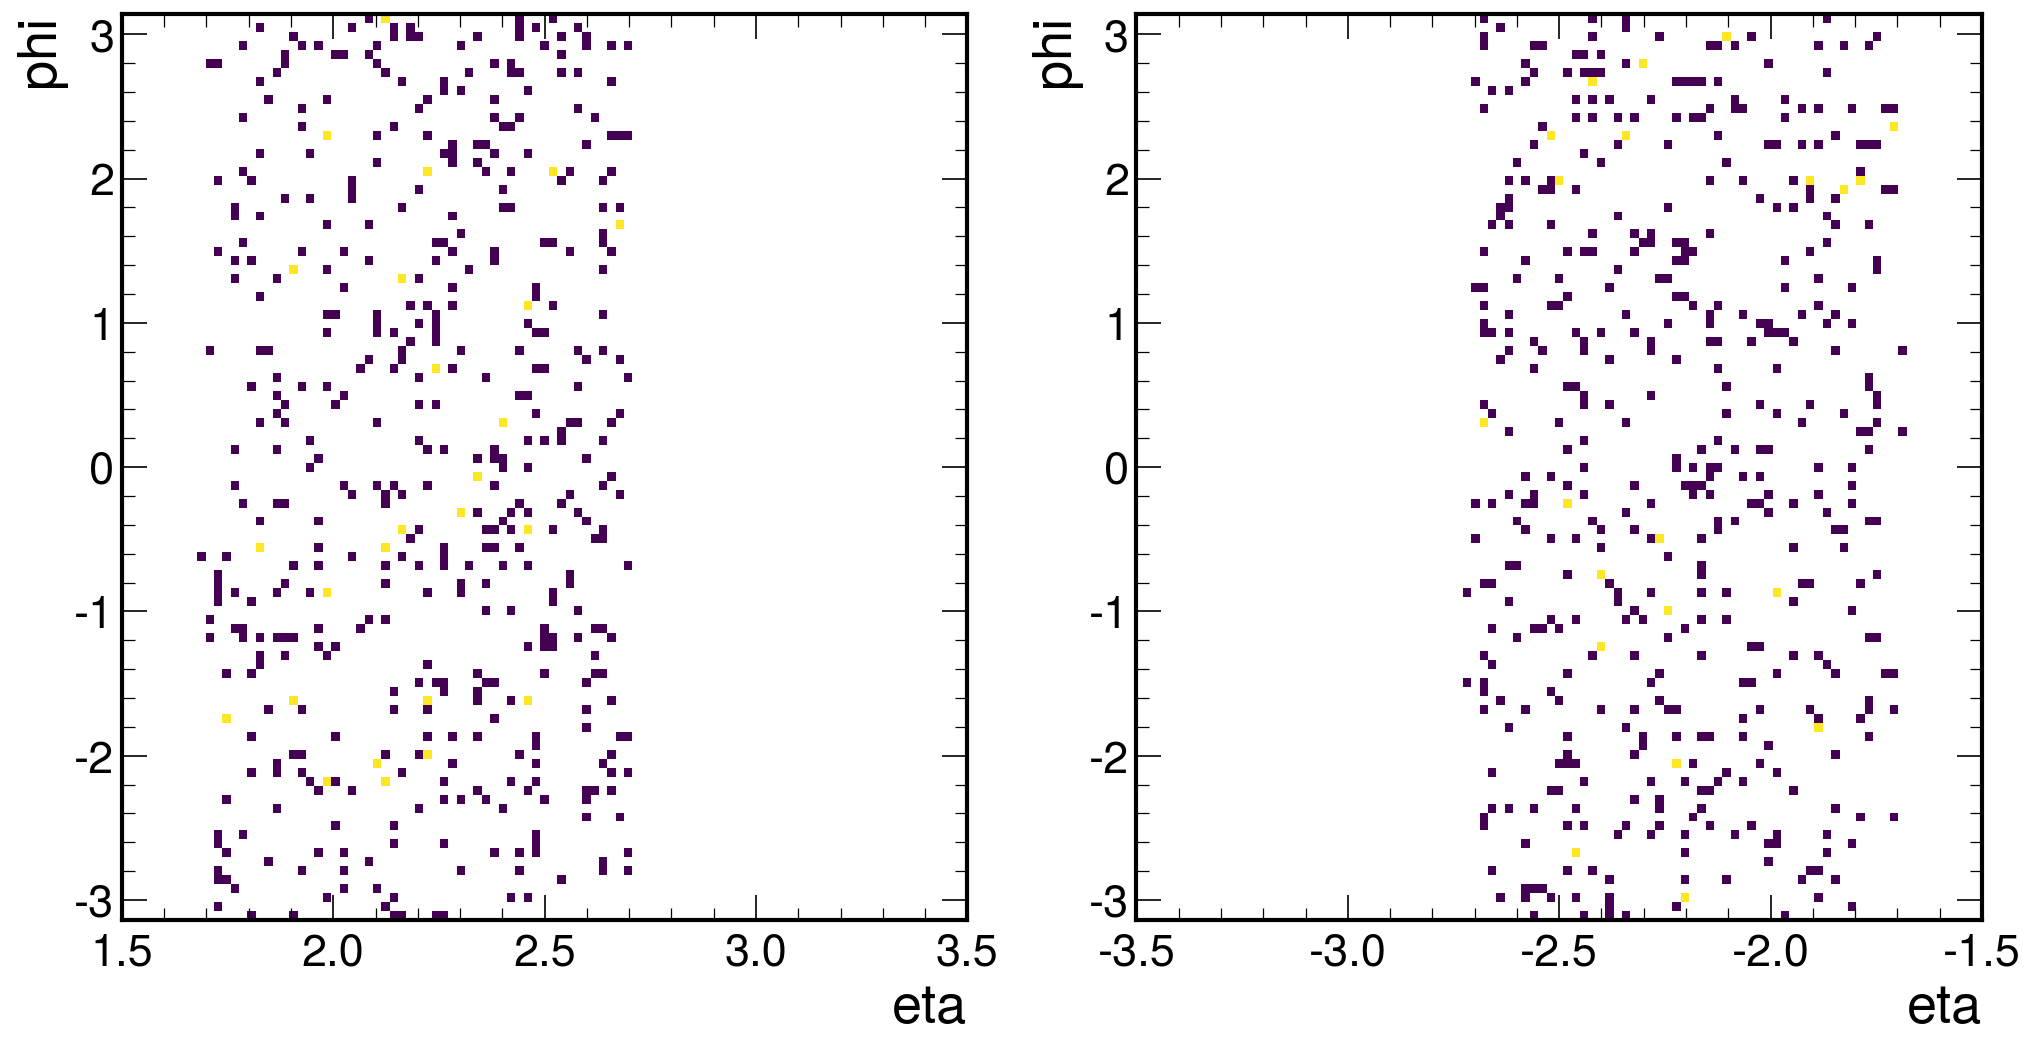

In [5]:
f, ax = plt.subplots(1,2, figsize=(16,8), dpi=150)

zmaskP = df_calo.stsCP_trackster_barycenter_eta > 0 
zmaskM = df_calo.stsCP_trackster_barycenter_eta < 0 

ax[0].hist2d(np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskP].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((1.5,3.5),(-3.14,3.14)), cmin=1)
ax[0].set_xlabel("eta")
ax[0].set_ylabel("phi")

ax[1].hist2d(np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_eta)),
             np.array(ak.flatten(df_calo[zmaskM].stsCP_trackster_barycenter_phi)),
           bins=(101,101), range=((-3.5,-1.5),(-3.14,3.14)), cmin=1)
ax[1].set_xlabel("eta")
ax[1].set_ylabel("phi")


In [6]:
import numba

@numba.njit
def in_window(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z, builder):
    deta = 0.1
    dphi = 0.2
    for c_eta, c_phi, c_z, t_eta, t_phi, t_z in zip(calo_eta, calo_phi, calo_z, track_eta, track_phi, track_z):
        builder.begin_list()
        for (ceta, cphi, cz, teta,tphi, tz) in zip(c_eta, c_phi, c_z, t_eta, t_phi, t_z):
            #print(cz, tz, ceta, teta, cphi,tphi)
            same_z = np.sign(cz) == np.sign(tz)
            in_eta = abs(ceta- teta) < deta
            in_phi = abs(((cphi - tphi + np.pi) % (2 * np.pi) - np.pi)) < dphi
            builder.append(same_z & in_eta & in_phi)
        builder.end_list()
    return builder

In [7]:
A = ak.argcartesian([df_calo.stsCP_trackster_barycenter_eta, df_track.trackster_barycenter_eta], axis=1)

In [8]:
A[0].tolist()

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10)]

In [9]:
ak.num(df_calo.stsCP_trackster_barycenter_eta)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='500 * int64'>

In [10]:
ak.num(df_track.trackster_barycenter_eta)

<Array [11, 4, 3, 5, 8, ... 7, 12, 11, 15, 7] type='500 * int64'>

In [11]:
calo_idx, track_idx = ak.unzip(A)

In [12]:
df_calo.eta = df_calo.stsCP_trackster_barycenter_eta
df_calo.phi = df_calo.stsCP_trackster_barycenter_phi
df_calo.z = df_calo.stsCP_barycenter_z

df_track.eta = df_track.trackster_barycenter_eta
df_track.phi = df_track.trackster_barycenter_phi
df_track.z = df_track.barycenter_z

In [13]:
all_calo_eta = df_calo.stsCP_trackster_barycenter_eta[calo_idx]
all_calo_phi = df_calo.stsCP_trackster_barycenter_phi[calo_idx]
all_calo_z = df_calo.stsCP_barycenter_z[calo_idx]

all_track_eta = df_track.trackster_barycenter_eta[track_idx]
all_track_phi = df_track.trackster_barycenter_phi[track_idx]
all_track_z = df_track.barycenter_z[track_idx]

In [14]:
%%timeit

out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

1.32 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
out = in_window(all_calo_eta, all_calo_phi, all_calo_z, all_track_eta, all_track_phi,  all_track_z, ak.ArrayBuilder())

In [16]:
goodpairs = A[out]

In [17]:
out[1].tolist()

[True, True, False, False, False, False, True, True]

In [18]:
goodpairs[0].tolist()

[(0, 0), (0, 1), (0, 2), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10)]

In [23]:
df_calo.eta[0].tolist()

[-2.5794811248779297,
 -2.5776336193084717,
 -2.9383702278137207,
 -2.7893142700195312,
 2.5890557765960693,
 2.5811634063720703,
 2.5637543201446533,
 2.581021785736084,
 2.5353291034698486,
 2.5759429931640625,
 2.5782294273376465,
 2.5781662464141846,
 2.5953128337860107,
 2.600846529006958,
 2.576669454574585,
 2.5776920318603516]

In [24]:
df_track.eta[0].tolist()

[-2.618563175201416,
 -2.5765695571899414,
 2.5765857696533203,
 2.582223653793335,
 2.5786471366882324]

In [25]:
df_calo.phi[0].tolist()

[2.4585931301116943,
 2.4595751762390137,
 2.828550100326538,
 2.1432077884674072,
 -0.543801486492157,
 -0.6391044855117798,
 -0.6381824016571045,
 -0.6354612708091736,
 -0.6352533102035522,
 -0.6745470762252808,
 -0.6829099059104919,
 -0.6888225674629211,
 -0.5374698042869568,
 -0.7152537703514099,
 -0.67460697889328,
 -0.6745836138725281]

In [26]:
df_track.phi[0].tolist()

[2.5129916667938232,
 2.4586222171783447,
 -0.6130256652832031,
 -0.5433849692344666,
 -0.674899160861969]